<a href="https://colab.research.google.com/github/fcochaux/estudio_parcial_2/blob/main/Estudio_parcial_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Acceso a repositorio:

In [ ]:
!git clone "https://github.com/fcochaux/estudio_parcial_2.git"

Cloning into 'estudio_parcial_2'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 29 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), done.


El siguiente código impide la generación de mensajes de advertencia:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Carga de librerías:

In [ ]:
# procesamiento

import numpy as np
import pandas as pd

# visualización

import matplotlib.pyplot as plt
import seaborn as sns

# aprendizaje

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

# 1) Preparación del conjunto de datos

Lectura de la base de datos:

__Fuente de información__: https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

In [ ]:
# lectura del conjunto de datos
df = pd.read_csv('/content/estudio_parcial_2/datos/heart.csv')
# convierte nombres a minúsculas
df.columns = df.columns.str.lower()
# revisa 5 casos al azar
df.sample(5)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
268,54,1,0,122,286,0,0,116,1,3.2,1,2,2,0
189,41,1,0,110,172,0,0,158,0,0.0,2,0,3,0
24,40,1,3,140,199,0,1,178,1,1.4,2,0,3,1
69,62,0,0,124,209,0,1,163,0,0.0,2,0,2,1
61,54,1,1,108,309,0,1,156,0,0.0,2,0,3,1


Revisión de características de la base:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


La base tiene 303 observaciones y 14 variables. En ningún caso se presentaron faltantes. A continuación, realizo histogramas de las variables numéricas para detectar cualquier particularidad:

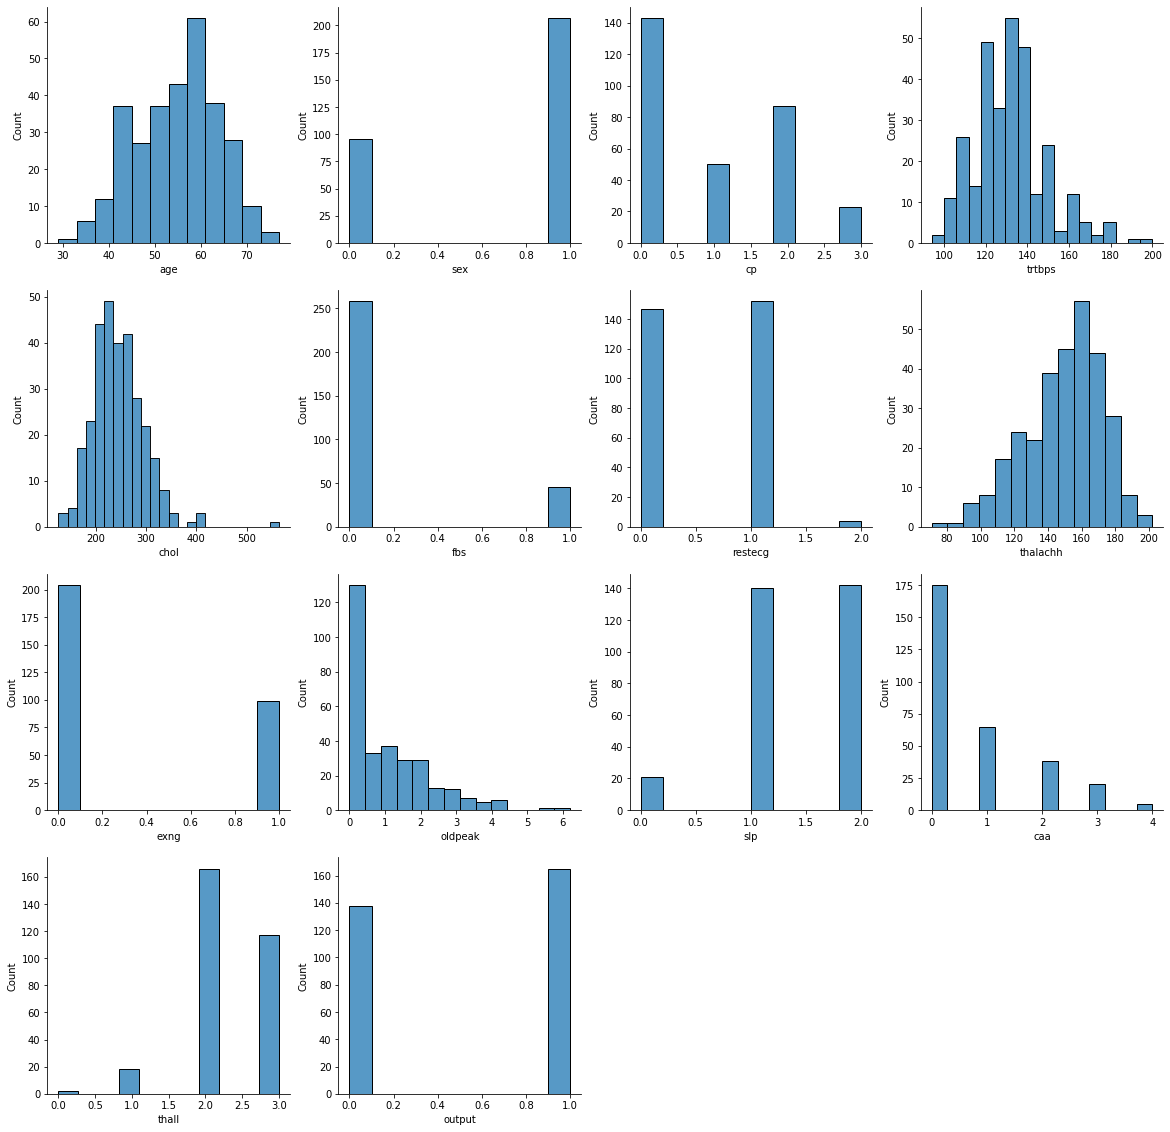

In [ ]:
figure, axis = plt.subplots(4, 4, figsize=(20, 20))
fila = -1
columna = -1
for k in df.describe().columns:
  columna = columna + 1
  if columna == 4:
    columna = 0
  if columna == 0:
    fila = fila + 1
  if fila == 4:
    fila = 0
  sns.histplot(df[k], ax=axis[fila,columna])
figure.delaxes(axis[3,2])
figure.delaxes(axis[3,3])
sns.despine(figure)

Se observa lo siguiente:
1. Las variables `sex`, `fbs`, `exng` y `output` son binarias.
2. Las variables `cp`, `restecg`, `slp`, `caa` y `thall` deben tener tratamiento de variables enteras.

Es posible que las variables de segundo grupo incluyan variables categóricas. Revisando el diccionario, se confirma esta situación para los siguientes casos: `cp` y `rest_ecg`. Las otras, parece, habrá que dejarlas como numéricas.

Ahora, sin haber variables de identificación, se revisan los posibles duplicados:

In [ ]:
df[df.duplicated()]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


Se encuentró un duplicado, el cual se elimina de inmediato:

In [ ]:
print(f'Antes de eliminar duplicados: {df.shape[0]} observaciones.')
df = df.drop_duplicates()
print(f'Después de eliminar duplicados: {df.shape[0]} observaciones.')

Antes de eliminar duplicados: 303 observaciones.
Después de eliminar duplicados: 302 observaciones.


Es posible que las variables `chol` y `oldpeak` tengan valores atípicos, por lo que se revisan sus diagramas de caja:

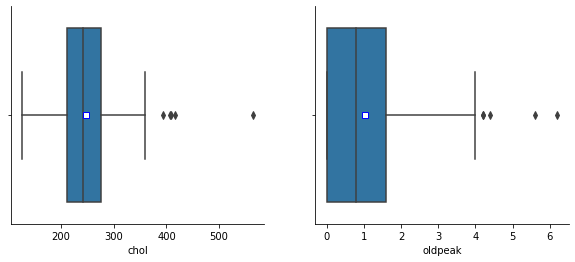

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(df['chol'], ax=axis[0], showmeans=True,
              meanprops={"marker":"s","markerfacecolor":"white",
                         "markeredgecolor":"blue"})
sns.boxplot(df['oldpeak'], ax=axis[1], showmeans=True,
              meanprops={"marker":"s","markerfacecolor":"white",
                         "markeredgecolor":"blue"})
sns.despine(figure)

Se identifican los valores atípicos usando el criterio de rango intercuantílico, convirtiendolos a nulo:

In [ ]:
df['chol'] = df['chol'][df['chol'].between(
    df['chol'].quantile(.25) - 1.5 * (df['chol'].quantile(.75) - df['chol'].quantile(.25)),
     df['chol'].quantile(.75) + 1.5 * (df['chol'].quantile(.75) - df['chol'].quantile(.25)),
     inclusive=True)]
df['oldpeak'] = df['oldpeak'][df['oldpeak'].between(
    df['oldpeak'].quantile(.25) - 1.5 * (df['oldpeak'].quantile(.75) - df['oldpeak'].quantile(.25)),
     df['oldpeak'].quantile(.75) + 1.5 * (df['oldpeak'].quantile(.75) - df['oldpeak'].quantile(.25)),
     inclusive=True)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trtbps    302 non-null    int64  
 4   chol      297 non-null    float64
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalachh  302 non-null    int64  
 8   exng      302 non-null    int64  
 9   oldpeak   297 non-null    float64
 10  slp       302 non-null    int64  
 11  caa       302 non-null    int64  
 12  thall     302 non-null    int64  
 13  output    302 non-null    int64  
dtypes: float64(2), int64(12)
memory usage: 35.4 KB


Como se perderían cerca del 1% de observaciones, se decide eliminar los casos detectados como atípicos:

In [ ]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       292 non-null    int64  
 1   sex       292 non-null    int64  
 2   cp        292 non-null    int64  
 3   trtbps    292 non-null    int64  
 4   chol      292 non-null    float64
 5   fbs       292 non-null    int64  
 6   restecg   292 non-null    int64  
 7   thalachh  292 non-null    int64  
 8   exng      292 non-null    int64  
 9   oldpeak   292 non-null    float64
 10  slp       292 non-null    int64  
 11  caa       292 non-null    int64  
 12  thall     292 non-null    int64  
 13  output    292 non-null    int64  
dtypes: float64(2), int64(12)
memory usage: 34.2 KB


Verificación:

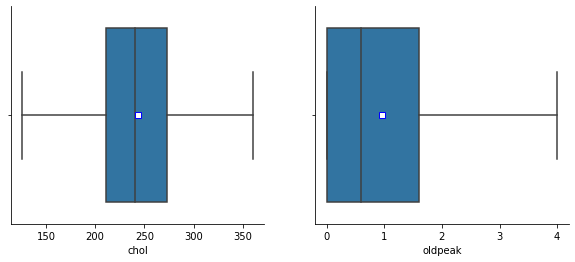

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(df['chol'], ax=axis[0], showmeans=True,
              meanprops={"marker":"s","markerfacecolor":"white",
                         "markeredgecolor":"blue"})
sns.boxplot(df['oldpeak'], ax=axis[1], showmeans=True,
              meanprops={"marker":"s","markerfacecolor":"white",
                         "markeredgecolor":"blue"})
sns.despine(figure)

Finalmente, reviso las frecuencias en las variables categóricas:

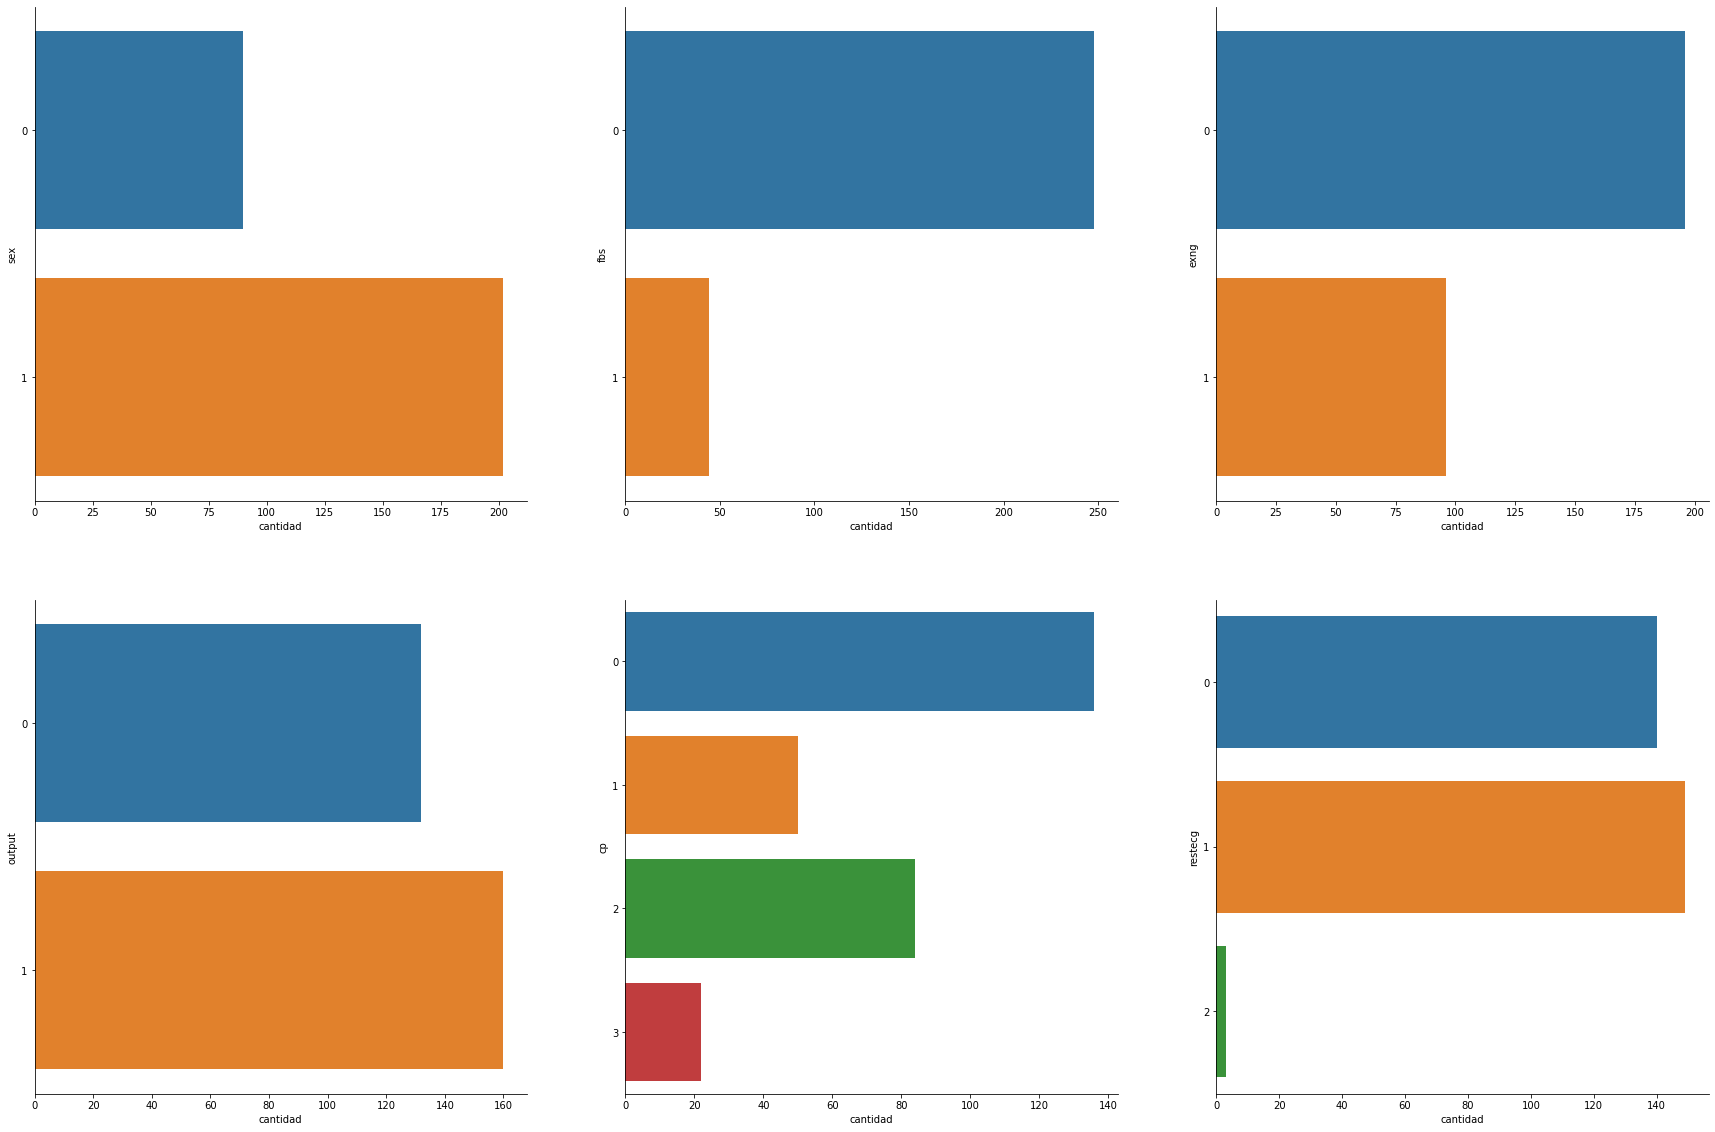

In [ ]:
figure, axis = plt.subplots(2, 3, figsize=(30, 20))
fila = -1
columna = -1
for k in ['sex','fbs','exng','output','cp','restecg']:
  columna = columna + 1
  if columna == 3:
    columna = 0
  if columna == 0:
    fila = fila + 1
  if fila == 2:
    fila = 0
  cuadro = df[[k]].groupby(k)[k] \
                  .count() \
                  .reset_index(name='cantidad')
  cuadro[k] = cuadro[k].astype(str)
  sns.barplot(data = cuadro, y = k, x = 'cantidad', ax=axis[fila,columna])
#figure.delaxes(axis[4,1])
sns.despine(figure)

En ningún caso parece haber problema.

Para convertir las variables categóricas, realizo su conversión a variables binarias:

In [ ]:
for k in ['sex','fbs','exng','cp','restecg']:
          onehotencoder = OneHotEncoder()
          var = onehotencoder.fit_transform(df[[k]])
          nombres = np.array([k + str(h) for h in onehotencoder.categories_[0]])
          df[nombres] = var.toarray()
          del df[k]
df.sample(5)

,age,trtbps,chol,thalachh,oldpeak,slp,caa,thall,output,sex0,...,fbs1,exng0,exng1,cp0,cp1,cp2,cp3,restecg0,restecg1,restecg2
192,54,120,188.0,113,1.4,1,1,3,0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
31,65,120,177.0,140,0.4,2,0,3,1,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
148,44,120,226.0,169,0.0,2,0,2,1,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
242,64,145,212.0,132,2.0,1,2,1,0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
41,48,130,245.0,180,0.2,1,0,2,1,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# 2) Modelamiento

División de datos:

In [ ]:
X = df.loc[:, ~df.columns.isin(['output'])]
Y = df['output']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, stratify = Y)

Pipeline para escoger el mejor modelo:

In [ ]:
pipeline = Pipeline([
    ('poly', 'passthrough'),
    ('normalizer', StandardScaler()),
    ('classifier',  LogisticRegression(multi_class='multinomial', solver='lbfgs'))
])

## 2.1) Regresión logística

Espacio para los hiperparámetros:

In [ ]:
param_grid = [
    {
        'poly': [PolynomialFeatures()],
        'poly__degree': [1, 2, 3],
        'normalizer': [StandardScaler(), MinMaxScaler()],
        'classifier__penalty': ['none', 'l1', 'l2'],
        'classifier__C': [0.01, 0.1, 1.],
        'classifier__class_weight': ['balanced', None]
    }
]

Función para búsqueda del mejor modelo:

In [ ]:
grid = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring = ['precision', 'recall', 'f1'],
                    n_jobs = 1, refit = 'f1', cv = 5, return_train_score = True, verbose = 2)

Búsqueda del mejor modelo:

In [ ]:
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.1s
[CV] END classifier__C=0.01, classifier__class_weight=balanced, classifier__penalty=none, normalizer=StandardScaler(), poly=PolynomialFeatures(), poly__degree=1; total time=   0.0s
[CV] END classifier__C=0.01, cla

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', 'passthrough'),
                                       ('normalizer', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(multi_class='multinomial'))]),
             n_jobs=1,
             param_grid=[{'classifier__C': [0.01, 0.1, 1.0],
                          'classifier__class_weight': ['balanced', None],
                          'classifier__penalty': ['none', 'l1', 'l2'],
                          'normalizer': [StandardScaler(), MinMaxScaler()],
                          'poly': [PolynomialFeatures(degree=3)],
                          'poly__degree': [1, 2, 3]}],
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1'], verbose=2)

Se revisan los mejores parámetros resultantes:

In [ ]:
grid.best_params_

{'classifier__C': 0.01,
 'classifier__class_weight': None,
 'classifier__penalty': 'l2',
 'normalizer': StandardScaler(),
 'poly': PolynomialFeatures(degree=3),
 'poly__degree': 3}

Predicciones usando el mejor modelo:

In [ ]:
train_val_preds = grid.best_estimator_.predict(X_train)
test_preds = grid.best_estimator_.predict(X_test)

Matriz de confusión:

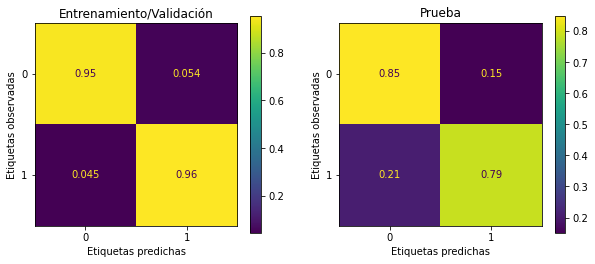

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

train_val_cm = confusion_matrix(Y_train, train_val_preds, labels = grid.best_estimator_.classes_, normalize = 'true')
train_val_disp = ConfusionMatrixDisplay(confusion_matrix = train_val_cm, display_labels = grid.best_estimator_.classes_)
train_val_disp.plot(ax = axes[0])
axes[0].set_title('Entrenamiento/Validación')
axes[0].set_ylabel('Etiquetas observadas')
axes[0].set_xlabel('Etiquetas predichas')

test_cm = confusion_matrix(Y_test, test_preds, labels = grid.best_estimator_.classes_, normalize = 'true')
test_disp = ConfusionMatrixDisplay(confusion_matrix = test_cm, display_labels = grid.best_estimator_.classes_)
test_disp.plot(ax = axes[1])
axes[1].set_title('Prueba')
axes[1].set_ylabel('Etiquetas observadas')
axes[1].set_xlabel('Etiquetas predichas')

plt.show()

Métricas:

In [ ]:
print(f'Precisión:')
print(f"- Entrenamiento/Validación: {precision_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {precision_score(Y_test, test_preds,average='weighted'):.2f}")
print(f'Sensibilidad (recall):')
print(f"- Entrenamiento/Validación: {recall_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {recall_score(Y_test, test_preds,average='weighted'):.2f}")
print(f'F1:')
print(f"- Entrenamiento/Validación: {f1_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {f1_score(Y_test, test_preds,average='weighted'):.2f}")

Precisión:
- Entrenamiento/Validación: 0.95
- Prueba: 0.82
Sensibilidad (recall):
- Entrenamiento/Validación: 0.95
- Prueba: 0.82
F1:
- Entrenamiento/Validación: 0.95
- Prueba: 0.82


Este parece ser un escenario de sobreajuste, ya que las métricas de entrenamiento son mayores a las de prueba.

## 2.2) Máquinas de vectores de soporte

Pipeline para escoger el mejor modelo:

In [ ]:
pipe = Pipeline([('reduce_dim', PCA()), ('clf', SVC())])

Espacio para los hiperparámetros:

In [ ]:
param_grid2 = dict(reduce_dim__n_components=[2, 5, 10],
                   clf__C=[0.1, 10, 100])

Función para búsqueda del mejor modelo:

In [ ]:
grid2 = GridSearchCV(estimator = pipe, param_grid = param_grid2,
                     scoring = ['precision', 'recall', 'f1'], n_jobs = 1,
                     refit = 'f1', cv = 5, return_train_score = True,
                     verbose = 2)

Búsqueda del mejor modelo:

In [ ]:
grid2.fit(X_train, Y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .............clf__C=0.1, reduce_dim__n_components=2; total time=   0.0s
[CV] END .............clf__C=0.1, reduce_dim__n_components=2; total time=   0.0s
[CV] END .............clf__C=0.1, reduce_dim__n_components=2; total time=   0.0s
[CV] END .............clf__C=0.1, reduce_dim__n_components=2; total time=   0.0s
[CV] END .............clf__C=0.1, reduce_dim__n_components=2; total time=   0.0s
[CV] END .............clf__C=0.1, reduce_dim__n_components=5; total time=   0.0s
[CV] END .............clf__C=0.1, reduce_dim__n_components=5; total time=   0.0s
[CV] END .............clf__C=0.1, reduce_dim__n_components=5; total time=   0.0s
[CV] END .............clf__C=0.1, reduce_dim__n_components=5; total time=   0.0s
[CV] END .............clf__C=0.1, reduce_dim__n_components=5; total time=   0.0s
[CV] END ............clf__C=0.1, reduce_dim__n_components=10; total time=   0.0s
[CV] END ............clf__C=0.1, reduce_dim__n_co

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('reduce_dim', PCA()), ('clf', SVC())]),
             n_jobs=1,
             param_grid={'clf__C': [0.1, 10, 100],
                         'reduce_dim__n_components': [2, 5, 10]},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1'], verbose=2)

Parámetros resultantes:

In [ ]:
grid2.best_params_

{'clf__C': 0.1, 'reduce_dim__n_components': 5}

Predicciones usando el mejor modelo:

In [ ]:
train_val_preds = grid2.best_estimator_.predict(X_train)
test_preds = grid2.best_estimator_.predict(X_test)

Matriz de confusión:

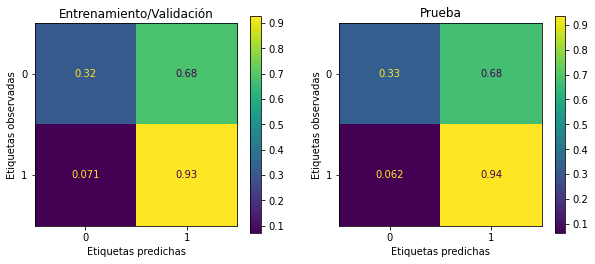

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

train_val_cm = confusion_matrix(Y_train, train_val_preds,
                                labels = grid2.best_estimator_.classes_,
                                normalize = 'true')
train_val_disp = ConfusionMatrixDisplay(confusion_matrix = train_val_cm,
                                        display_labels = grid2.best_estimator_.classes_)
train_val_disp.plot(ax = axes[0])
axes[0].set_title('Entrenamiento/Validación')
axes[0].set_ylabel('Etiquetas observadas')
axes[0].set_xlabel('Etiquetas predichas')

test_cm = confusion_matrix(Y_test, test_preds,
                           labels = grid2.best_estimator_.classes_,
                           normalize = 'true')
test_disp = ConfusionMatrixDisplay(confusion_matrix = test_cm,
                                   display_labels = grid2.best_estimator_.classes_)
test_disp.plot(ax = axes[1])
axes[1].set_title('Prueba')
axes[1].set_ylabel('Etiquetas observadas')
axes[1].set_xlabel('Etiquetas predichas')

plt.show()

Métricas:

In [ ]:
print(f'Precisión:')
print(f"- Entrenamiento/Validación: {precision_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {precision_score(Y_test, test_preds,average='weighted'):.2f}")
print(f'Sensibilidad (recall):')
print(f"- Entrenamiento/Validación: {recall_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {recall_score(Y_test, test_preds,average='weighted'):.2f}")
print(f'F1:')
print(f"- Entrenamiento/Validación: {f1_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {f1_score(Y_test, test_preds,average='weighted'):.2f}")

Precisión:
- Entrenamiento/Validación: 0.70
- Prueba: 0.71
Sensibilidad (recall):
- Entrenamiento/Validación: 0.65
- Prueba: 0.66
F1:
- Entrenamiento/Validación: 0.61
- Prueba: 0.62


En este caso no parece haber sobreajuste, aunque las métricas son relativamente bajas, todas inferiores al 72%.

## 2.3) Aprendizaje basado en árboles de decisión

Pipeline para escoger el mejor modelo:

In [ ]:
param_grid3 = [
    {
        'classifier': [DecisionTreeClassifier(random_state = 20)],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10],
        'classifier__class_weight': ['balanced', None]
    }
]

Función para búsqueda del mejor modelo:

In [ ]:
grid3 = GridSearchCV(estimator = pipeline, param_grid = param_grid3,
                     scoring = ['precision', 'recall', 'f1'], n_jobs = 1,
                     refit = 'f1', cv = 5, return_train_score = True,
                     verbose = 2)

Búsqueda del mejor modelo:

In [ ]:
grid3.fit(X_train, Y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END classifier=DecisionTreeClassifier(random_state=20), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_depth=2; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=20), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_depth=2; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=20), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_depth=2; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=20), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_depth=2; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=20), classifier__class_weight=balanced, classifier__criterion=gini, classifier__max_depth=2; total time=   0.0s
[CV] END classifier=DecisionTreeClassifier(random_state=20), classifier__class_weight=balanced, cl

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', 'passthrough'),
                                       ('normalizer', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(multi_class='multinomial'))]),
             n_jobs=1,
             param_grid=[{'classifier': [DecisionTreeClassifier(class_weight='balanced',
                                                                max_depth=5,
                                                                random_state=20)],
                          'classifier__class_weight': ['balanced', None],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                    10]}],
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1'], verbose=2)

Parámetros resultantes:

In [ ]:
grid3.best_params_

{'classifier': DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=20),
 'classifier__class_weight': 'balanced',
 'classifier__criterion': 'gini',
 'classifier__max_depth': 5}

Predicciones usando el mejor modelo:

In [ ]:
train_val_preds = grid3.best_estimator_.predict(X_train)
test_preds = grid3.best_estimator_.predict(X_test)

Matriz de confusión:

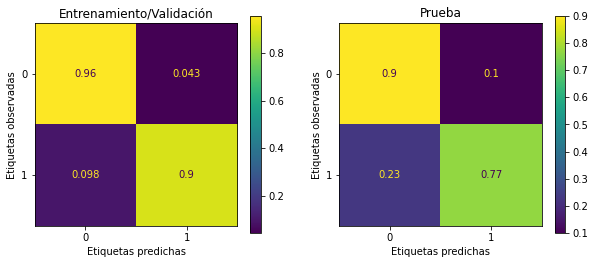

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

train_val_cm = confusion_matrix(Y_train, train_val_preds,
                                labels = grid3.best_estimator_.classes_,
                                normalize = 'true')
train_val_disp = ConfusionMatrixDisplay(confusion_matrix = train_val_cm,
                                        display_labels = grid3.best_estimator_.classes_)
train_val_disp.plot(ax = axes[0])
axes[0].set_title('Entrenamiento/Validación')
axes[0].set_ylabel('Etiquetas observadas')
axes[0].set_xlabel('Etiquetas predichas')

test_cm = confusion_matrix(Y_test, test_preds,
                           labels = grid3.best_estimator_.classes_,
                           normalize = 'true')
test_disp = ConfusionMatrixDisplay(confusion_matrix = test_cm,
                                   display_labels = grid3.best_estimator_.classes_)
test_disp.plot(ax = axes[1])
axes[1].set_title('Prueba')
axes[1].set_ylabel('Etiquetas observadas')
axes[1].set_xlabel('Etiquetas predichas')

plt.show()

Métricas:

In [ ]:
print(f'Precisión:')
print(f"- Entrenamiento/Validación: {precision_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {precision_score(Y_test, test_preds,average='weighted'):.2f}")
print(f'Sensibilidad (recall):')
print(f"- Entrenamiento/Validación: {recall_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {recall_score(Y_test, test_preds,average='weighted'):.2f}")
print(f'F1:')
print(f"- Entrenamiento/Validación: {f1_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {f1_score(Y_test, test_preds,average='weighted'):.2f}")

Precisión:
- Entrenamiento/Validación: 0.93
- Prueba: 0.84
Sensibilidad (recall):
- Entrenamiento/Validación: 0.93
- Prueba: 0.83
F1:
- Entrenamiento/Validación: 0.93
- Prueba: 0.83


Con este modelo parece haber sobreajuste, ya que las métricas de entrenamiento son superiores a las de prueba en 0.5, aproximadamente.

## 2.4) Bosques aleatorios

Pipeline para escoger el mejor modelo:

In [ ]:
param_grid4 = [
    {
        'classifier': [RandomForestClassifier(random_state = 20)],
        'classifier__n_estimators': [130,190,400], 
        'classifier__max_features': ['sqrt','log2'], 
        'classifier__max_depth': [15,20,25],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__min_samples_leaf' : [1,3,5],
    }
]

Función para búsqueda del mejor modelo:

In [ ]:
grid4 = GridSearchCV(estimator = pipeline, param_grid = param_grid4,
                     scoring = ['precision', 'recall', 'f1'], n_jobs = 1,
                     refit = 'f1', cv = 5, return_train_score = True,
                     verbose = 2)

Búsqueda del mejor modelo:

In [ ]:
grid4.fit(X_train, Y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END classifier=RandomForestClassifier(random_state=20), classifier__criterion=gini, classifier__max_depth=15, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=130; total time=   0.2s
[CV] END classifier=RandomForestClassifier(random_state=20), classifier__criterion=gini, classifier__max_depth=15, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=130; total time=   0.2s
[CV] END classifier=RandomForestClassifier(random_state=20), classifier__criterion=gini, classifier__max_depth=15, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=130; total time=   0.2s
[CV] END classifier=RandomForestClassifier(random_state=20), classifier__criterion=gini, classifier__max_depth=15, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__n_estimators=130; total time=   0.2s
[CV] END classifier=RandomFor

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', 'passthrough'),
                                       ('normalizer', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(multi_class='multinomial'))]),
             n_jobs=1,
             param_grid=[{'classifier': [RandomForestClassifier(max_depth=15,
                                                                max_features='sqrt',
                                                                min_samples_leaf=5,
                                                                n_estimators=130,
                                                                random_state=20)],
                          'classifier__criterion': ['gini', 'entropy'],
                          'classifier__max_depth': [15, 20, 25],
                          'classifier__max_features': ['sqrt', 'log2'],
                          'classifier__min_samples_leaf'

Parámetros resultantes:

In [ ]:
grid4.best_params_

{'classifier': RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=5,
                        n_estimators=130, random_state=20),
 'classifier__criterion': 'gini',
 'classifier__max_depth': 15,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 5,
 'classifier__n_estimators': 130}

Predicciones usando el mejor modelo:

In [ ]:
train_val_preds = grid4.best_estimator_.predict(X_train)
test_preds = grid4.best_estimator_.predict(X_test)

Matriz de confusión:

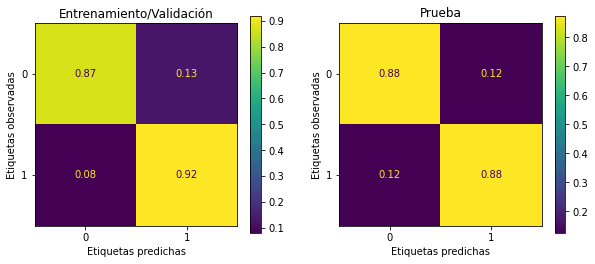

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

train_val_cm = confusion_matrix(Y_train, train_val_preds,
                                labels = grid4.best_estimator_.classes_,
                                normalize = 'true')
train_val_disp = ConfusionMatrixDisplay(confusion_matrix = train_val_cm,
                                        display_labels = grid4.best_estimator_.classes_)
train_val_disp.plot(ax = axes[0])
axes[0].set_title('Entrenamiento/Validación')
axes[0].set_ylabel('Etiquetas observadas')
axes[0].set_xlabel('Etiquetas predichas')

test_cm = confusion_matrix(Y_test, test_preds,
                           labels = grid4.best_estimator_.classes_,
                           normalize = 'true')
test_disp = ConfusionMatrixDisplay(confusion_matrix = test_cm,
                                   display_labels = grid4.best_estimator_.classes_)
test_disp.plot(ax = axes[1])
axes[1].set_title('Prueba')
axes[1].set_ylabel('Etiquetas observadas')
axes[1].set_xlabel('Etiquetas predichas')

plt.show()

Métricas:

In [ ]:
print(f'Precisión:')
print(f"- Entrenamiento/Validación: {precision_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {precision_score(Y_test, test_preds,average='weighted'):.2f}")
print(f'Sensibilidad (recall):')
print(f"- Entrenamiento/Validación: {recall_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {recall_score(Y_test, test_preds,average='weighted'):.2f}")
print(f'F1:')
print(f"- Entrenamiento/Validación: {f1_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {f1_score(Y_test, test_preds,average='weighted'):.2f}")

Precisión:
- Entrenamiento/Validación: 0.90
- Prueba: 0.88
Sensibilidad (recall):
- Entrenamiento/Validación: 0.90
- Prueba: 0.88
F1:
- Entrenamiento/Validación: 0.90
- Prueba: 0.88


## 2.5) Redes neuronales

Pipeline para escoger el mejor modelo:

In [ ]:
param_grid5 = [
    {
        'classifier': [MLPClassifier()],
        'classifier__hidden_layer_sizes': [(10,30,10),(20,)],
        'classifier__activation': ['tanh', 'relu'],
        'classifier__solver': ['sgd', 'adam'],
        'classifier__alpha': [0.0001, 0.05],
        'classifier__learning_rate': ['constant','adaptive']
     
    }
]

Función para búsqueda del mejor modelo:

In [ ]:
grid5 = GridSearchCV(estimator = pipeline, param_grid = param_grid5,
                     scoring = ['precision', 'recall', 'f1'], n_jobs = 1,
                     refit = 'f1', cv = 5, return_train_score = True,
                     verbose = 2)

Búsqueda del mejor modelo:

In [ ]:
grid5.fit(X_train, Y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END classifier=MLPClassifier(), classifier__activation=tanh, classifier__alpha=0.0001, classifier__hidden_layer_sizes=(10, 30, 10), classifier__learning_rate=constant, classifier__solver=sgd; total time=   0.2s
[CV] END classifier=MLPClassifier(), classifier__activation=tanh, classifier__alpha=0.0001, classifier__hidden_layer_sizes=(10, 30, 10), classifier__learning_rate=constant, classifier__solver=sgd; total time=   0.2s
[CV] END classifier=MLPClassifier(), classifier__activation=tanh, classifier__alpha=0.0001, classifier__hidden_layer_sizes=(10, 30, 10), classifier__learning_rate=constant, classifier__solver=sgd; total time=   0.2s
[CV] END classifier=MLPClassifier(), classifier__activation=tanh, classifier__alpha=0.0001, classifier__hidden_layer_sizes=(10, 30, 10), classifier__learning_rate=constant, classifier__solver=sgd; total time=   0.2s
[CV] END classifier=MLPClassifier(), classifier__activation=tanh, classifi

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly', 'passthrough'),
                                       ('normalizer', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(multi_class='multinomial'))]),
             n_jobs=1,
             param_grid=[{'classifier': [MLPClassifier(activation='tanh',
                                                       hidden_layer_sizes=(20,),
                                                       learning_rate='adaptive')],
                          'classifier__activation': ['tanh', 'relu'],
                          'classifier__alpha': [0.0001, 0.05],
                          'classifier__hidden_layer_sizes': [(10, 30, 10),
                                                             (20,)],
                          'classifier__learning_rate': ['constant', 'adaptive'],
                          'classifier__solver': ['sgd', 'adam']}],
             r

Parámetros resultantes:

In [ ]:
train_val_preds = grid5.best_estimator_.predict(X_train)
test_preds = grid5.best_estimator_.predict(X_test)

Matriz de confusión:

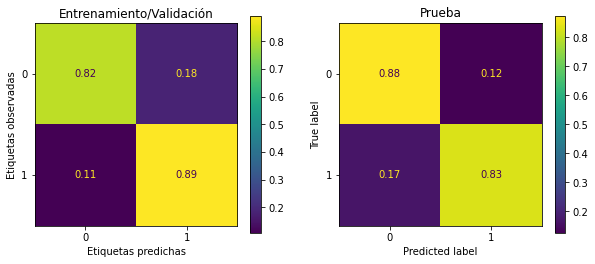

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

train_val_cm = confusion_matrix(Y_train, train_val_preds,
                                labels = grid5.best_estimator_.classes_,
                                normalize = 'true')
train_val_disp = ConfusionMatrixDisplay(confusion_matrix = train_val_cm,
                                        display_labels = grid5.best_estimator_.classes_)
train_val_disp.plot(ax = axes[0])
axes[0].set_title('Entrenamiento/Validación')
axes[0].set_ylabel('Etiquetas observadas')
axes[0].set_xlabel('Etiquetas predichas')

test_cm = confusion_matrix(Y_test, test_preds,
                           labels = grid5.best_estimator_.classes_, normalize = 'true')
test_disp = ConfusionMatrixDisplay(confusion_matrix = test_cm,
                                   display_labels = grid5.best_estimator_.classes_)
test_disp.plot(ax = axes[1])
axes[1].set_title('Prueba')
axes[0].set_ylabel('Etiquetas observadas')
axes[0].set_xlabel('Etiquetas predichas')

plt.show()

Métricas:

In [ ]:
print(f'Precisión:')
print(f"- Entrenamiento/Validación: {precision_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {precision_score(Y_test, test_preds,average='weighted'):.2f}")
print(f'Sensibilidad (recall):')
print(f"- Entrenamiento/Validación: {recall_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {recall_score(Y_test, test_preds,average='weighted'):.2f}")
print(f'F1:')
print(f"- Entrenamiento/Validación: {f1_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {f1_score(Y_test, test_preds,average='weighted'):.2f}")

Precisión:
- Entrenamiento/Validación: 0.86
- Prueba: 0.85
Sensibilidad (recall):
- Entrenamiento/Validación: 0.86
- Prueba: 0.85
F1:
- Entrenamiento/Validación: 0.86
- Prueba: 0.85


En este modelo no parece haber sobreajuste, ya que las métricas de entrenamiento y prueba son muy similares.

## 2.6) eXtreme Gradient Boosting (XGBoosting)

Entrenamiento con el modelo:

In [ ]:
clf = xgb.XGBClassifier()
clf.fit(X_train, Y_train, eval_set=[(X_test, Y_test)])

[0]	validation_0-error:0.193182
[1]	validation_0-error:0.193182
[2]	validation_0-error:0.181818
[3]	validation_0-error:0.181818
[4]	validation_0-error:0.181818
[5]	validation_0-error:0.170455
[6]	validation_0-error:0.113636
[7]	validation_0-error:0.113636
[8]	validation_0-error:0.102273
[9]	validation_0-error:0.113636
[10]	validation_0-error:0.102273
[11]	validation_0-error:0.090909
[12]	validation_0-error:0.090909
[13]	validation_0-error:0.090909
[14]	validation_0-error:0.102273
[15]	validation_0-error:0.090909
[16]	validation_0-error:0.090909
[17]	validation_0-error:0.090909
[18]	validation_0-error:0.090909
[19]	validation_0-error:0.090909
[20]	validation_0-error:0.102273
[21]	validation_0-error:0.102273
[22]	validation_0-error:0.102273
[23]	validation_0-error:0.102273
[24]	validation_0-error:0.102273
[25]	validation_0-error:0.113636
[26]	validation_0-error:0.125
[27]	validation_0-error:0.113636
[28]	validation_0-error:0.113636
[29]	validation_0-error:0.113636
[30]	validation_0-error

XGBClassifier()

Predicciones:

In [ ]:
train_val_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

Métricas:

In [ ]:
print(f'Precisión:')
print(f"- Entrenamiento/Validación: {precision_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {precision_score(Y_test, test_preds,average='weighted'):.2f}")
print(f'Sensibilidad (recall):')
print(f"- Entrenamiento/Validación: {recall_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {recall_score(Y_test, test_preds,average='weighted'):.2f}")
print(f'F1:')
print(f"- Entrenamiento/Validación: {f1_score(Y_train, train_val_preds,average='weighted'):.2f}")
print(f"- Prueba: {f1_score(Y_test, test_preds,average='weighted'):.2f}")

Precisión:
- Entrenamiento/Validación: 0.99
- Prueba: 0.86
Sensibilidad (recall):
- Entrenamiento/Validación: 0.99
- Prueba: 0.85
F1:
- Entrenamiento/Validación: 0.99
- Prueba: 0.85


Este es un escenario de sobreajuste, ya que el modelo se aprende casi perfectamente los datos de entrenamiento.

# 3) Elección del mejor modelo

Considerando que interesa detectar casos que van a sufrir ataques, la sensibilidad (recall), que es la proporción de casos que van a sufrir el ataque detectados, es la métrica más importante. A partir de esta métrica, se obtiene la siguiente comparación:

|Modelo | Entrenamiento | Prueba |
|--------|--------------|--------|
| Regresión logística | 0.95 | 0.82 |
| Máquinas de vectores de soporte | 0.65 | 0.66 |
| Aprendizaje basado en árboles de decisión | 0.93 | 0.83 |
| Bosques aleatorios | 0.90 | 0.88 |
| Redes neuronales | 0.86 | 0.85 |
| XGBoosting | 0.99 | 0.85 |

A partir de la comparación, se deduce que los modelos de regresión logística, aprendizaje basado en árboles de decisión y XGBoosting tienen sobreajuste. De los otros modelos, el modelo de bosques aleatorios tiene las mejores métricas. Sin embargo, comparado con redes neuronales, bien puede ser otro escenario de sobreajuste, aunque menos severo. En este sentido, se concluye que el mejor modelo es el de redes neuronales.